In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

In [2]:
batch_size = 64
nr_samples = 100
nr_samples_train = 50
data = np.random.uniform([0,0], [1,1], (nr_samples,2))
labels = np.sum(np.square(data-[.5,.5]), axis=1)<.09 # x^2 + y^2 < (0.3)^2

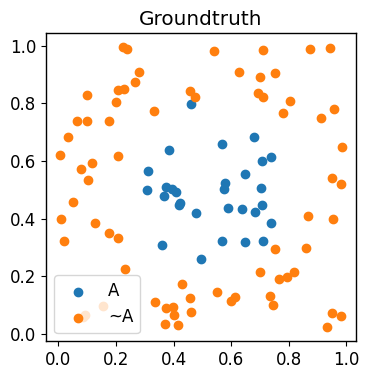

In [11]:
ds_train = tf.data.Dataset.from_tensor_slices((data[:nr_samples_train], labels[:nr_samples_train])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((data[nr_samples_train:], labels[nr_samples_train:])).batch(batch_size)

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0], data[labels][:,1], label='A')
plt.scatter(data[np.logical_not(labels)][:,0], data[np.logical_not(labels)][:, 1], label='~A')
plt.title("Groundtruth")
plt.legend()
plt.show()

In [12]:
A = ltn.Predicate.MLP([2], hidden_layer_sizes=(16,16))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2), semantics="exists")

In [13]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(data, labels):
    x_A = ltn.Variable("x_A", data[labels])
    x_not_A = ltn.Variable("x_not_A", data[tf.logical_not(labels)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level